# COMP0137 - Machine Vision : Homework #1

------------------------------

In [1]:
# Importing the required modules

import os, time, sys
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import cv2
import glob

%matplotlib inline

_Below, we introduce the functions we are going to use in the remainder of this notebook. They are mostly adapted versions of the functions used in the previous practicals._

In [103]:
def fitGaussianModel(data):    
    """
    Returns the mean and covariance for a set of multidimensaional data.  
    It is assumed that each column of the 2D array, data, contains a single data point.  
    The mean vector should be a dx1 vector with the mean value of the data. For this lab, the output is a 
    3 by 1 vector containing the RGB mean of the input pixels. The covariance should be a dxd covariance
    matrix. See the note at the top, which explains that using mean() is ok,
    but please compute the covariance yourself.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    
    Returns: 
    meanData -- d by 1 vector containing the mean value of the input data.
    covData -- d by d matrix containing the covariance of the input data.
    """

    nDim,nData = data.shape
    
    #TO DO (a): replace the placeholders for meanData and covData with the real equations.
    
    #calculate mean of data.  You can do this using the numpy command 'mean'
    meanData = np.mean(data, axis=1)
    
    #calculate covariance of data.  You should do this yourself to ensure you
    #understand how.  Check you have the right answer by comparing with the
    #numpy function np.cov().
    covData = np.eye(nDim)
    
    #Let's start by centering each column
    data_centered_indiv = np.copy(data)
    for k in range(nDim):
        data_centered_indiv[k] -= meanData[k]

    #We now compute each component of the covariance matrix
    for i in range(nDim):
        for j in range(nDim):
            covData[i, j] = (data_centered_indiv[i].T @ data_centered_indiv[j])/nData

    return meanData,covData 

In [147]:
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim,nData = data.shape
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
        
    #replace this
    data_centered_indiv = np.copy(data)
    for k in range(nDim):
        data_centered_indiv[k] -= gaussMean[k]

    like = ((2*np.pi)**(-nDim/2)) * (det(gaussCov)**(-1/2)) * np.exp((-1/2)*(data_centered_indiv.T @ inv(gaussCov) @ data_centered_indiv))  
    
    return like

In [146]:
def computePosterior(data, mean_a, mean_b, cov_a, cov_b, prior_a, prior_b):
    imY, imX, imZ = data.shape
    posteriorSkin = np.zeros([imY,imX])

    for cY in range(imY): 
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(data[cY,cX,:])
            thisPixelData = thisPixelData[:, np.newaxis] #To go from [R, G, B] to [[R], [G], [B]] bc that's our model
            
            #make sure you've filled in calcGaussianProb above.
            
            #calculate likelihood of this data given skin model
            likeSkin = calcGaussianProb(thisPixelData,mean_a,cov_a);
            #calculate likelihood of this data given non skin model
            likeNonSkin = calcGaussianProb(thisPixelData,mean_b,cov_b);
            
            
            #TO DO (c):  calculate posterior probability from likelihoods and 
            #priors using BAYES rule. Replace this: 
            posteriorSkin[cY,cX]= (likeSkin*prior_a)/(likeSkin*prior_a + likeNonSkin*prior_b)
            #posteriorSkin[cY,cX]= (likeNonSkin*priorNonSkin)/(likeSkin*priorSkin + likeNonSkin*priorNonSkin)
    return posteriorSkin

In [169]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # TO DO - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this       
        k = mixGaussEst['k']
        like = 0
        for nGauss in range(k):
            sigma = mixGaussEst['cov'][:, :, nGauss]
            mu = mixGaussEst['mean'][:, nGauss]
            w = mixGaussEst['weight'][nGauss]
            #like += w * ((2*np.pi)**(-nDims/2)) * (np.linalg.det(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d']))**(-1/2)) * np.exp( (-1/2) * (thisData - mu).T @ np.linalg.inv(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d'])) @ (thisData - mu)) * w
            like += w * multivariate_normal.pdf(thisData, mu, sigma, allow_singular=True) # We use this scipy function because we encounter too many numerical issues with the one above

        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item()                                                                       
                                                                                                       
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 8;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    #fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            #Total likelihood for all gaussians
            thisData = data[:, cData]
            denominator_like = 0
            for nGauss in range(k):
                sigma = mixGaussEst['cov'][:, :, nGauss]
                mu = mixGaussEst['mean'][:, nGauss]
                w = mixGaussEst['weight'][nGauss]
                #currentGaussianValue = w * ((2*np.pi)**(-nDims/2)) * (np.linalg.det(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d']))**(-1/2)) * np.exp( (-1/2) * (thisData - mu).T @ np.linalg.inv(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d'])) @ (thisData - mu)) * w
                currentGaussianValue = w * multivariate_normal.pdf(thisData, mu, sigma, allow_singular=True) # We use this scipy function because we encounter too many numerical issues with the one above
                denominator_like += currentGaussianValue
                postHidden[nGauss, cData] = currentGaussianValue
            postHidden[:, cData] = postHidden[:, cData]/denominator_like
            
            """
            for nGauss in range(k):
                sigma = mixGaussEst['cov'][:, :, nGauss]
                mu = mixGaussEst['mean'][:, nGauss]
                w = mixGaussEst['weight'][nGauss]
                #postHidden[nGauss, cData] = ((2*np.pi)**(-nDims/2)) * (np.linalg.det(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d']))**(-1/2)) * np.exp( (-1/2) * (thisData - mu).T @ np.linalg.inv(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d'])) @ (thisData - mu)) * w
                postHidden[nGauss, cData] = multivariate_normal.pdf(thisData, mu, sigma, allow_singular=True)
                postHidden[nGauss, cData] *= 1/denominator_like
            """

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            weightNumerator = 0
            for cData in range(nData):
                weightNumerator += postHidden[cGauss, cData]
            mixGaussEst['weight'][cGauss] = weightNumerator/np.sum(postHidden)
            
            
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            meanNumerator = np.zeros_like(mixGaussEst['mean'][:, 0])
            meanDenominator = 0
            for cData in range(nData):
                meanNumerator += postHidden[cGauss, cData] * data[:, cData]
                meanDenominator += postHidden[cGauss, cData]
            mixGaussEst['mean'][:,cGauss] = meanNumerator/meanDenominator

        """
        for cGauss in range(k):
            resp_matrix = np.diag(postHidden[cGauss, :])
            #mu_k = np.tile(mixGaussEst['mean'][:, cGauss], (nDims, 1))
            ones_vec = np.ones((1, nData))
            mu_k = np.reshape(mixGaussEst['mean'][:, cGauss], (-1, 1)) @ ones_vec
            data_centred = data - mu_k
            res = data_centred @ resp_matrix @ data_centred.T
            covDenominator = 0
            for cData in range(nData):
                covDenominator += postHidden[cGauss, cData]
            mixGaussEst['cov'][:,:,cGauss] = res/covDenominator
        """

        # TO DO (j):  Update covarance parameter based on weighted average of
        # square distance from update mean, where weights are given by
        # posterior probability associated with Gaussian
        for cGauss in range(k):
            mu_k = np.reshape(mixGaussEst['mean'][:, cGauss], (-1, 1))
            res = np.zeros((nDims, nDims))
            cov_denominator = 1e-8 #computational epsilon

            for cData in range(nData):
                r_i_k = postHidden[cGauss, cData]
                data_i_centred = data[:, cData] - mu_k
                res += r_i_k * data_i_centred @ data_i_centred.T
                cov_denominator += r_i_k
            
            mixGaussEst['cov'][:, :, cGauss] = res/cov_denominator
            
       
        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst


In [107]:
 ### ONLY COMMENTS
"""
        for cGauss in range(k):

            covDenominator = 0

            for percentage in range(100):
                data_p = data[:, int(percentage*0.01*nData):int((percentage+1)*0.01*nData)]
                nDataP = data_p.shape[1]
                res = np.zeros((nDims,nDims))
                resp_matrix = np.diag(postHidden[cGauss, int(percentage*0.01*nData):int((percentage+1)*0.01*nData)])
                #mu_k = np.tile(mixGaussEst['mean'][:, cGauss], (nDims, 1))
                ones_vec = np.ones((1, nDataP))
                mu_k = np.reshape(mixGaussEst['mean'][:, cGauss], (-1, 1)) @ ones_vec
                data_centred = data_p - mu_k
                res += data_centred @ resp_matrix @ data_centred.T

                for cData in range(int(percentage*0.01*nData),int((percentage+1)*0.01*nData)):
                    covDenominator += postHidden[cGauss, cData]
        
        
            mixGaussEst['cov'][:,:,cGauss] = res/covDenominator
"""

            
"""
        covNumerator = np.zeros_like(mixGaussEst['cov'][:, :, 0])
        covDenominator = 0
        mu_k = mixGaussEst['mean'][:,cGauss]
        for cData in range(nData):
            covNumerator += postHidden[cGauss, cData] * ((data[:, cData] - mu_k) @ (data[:, cData] - mu_k).T)
            covDenominator += postHidden[cGauss, cData]
        mixGaussEst['cov'][:,:,cGauss] = covNumerator/covDenominator
"""
            
            # draw the new solution
"""
        drawEMData2d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()
"""

'\n       drawEMData2d(data, mixGaussEst)\n       time.sleep(0.7)\n       fig.canvas.draw()\n'

In [143]:
def getResultLike(img, mixGaussSkin, mixGaussNonSkin, priorSkin, priorNonSkin): 
    
    h, w, c = img.shape
    posteriorSkin = np.zeros((h,w))    
    oui = h
    ouioui = w

    for i in range(oui):
        for j in range(ouioui):
            #print('i = '+str(i))
            #print('j = '+str(j))
        #extract this pixel's data
            thisPixelData = img[i, j, :]
            #thisPixelData = np.double(img[cY,cX,:])
            #thisPixelData = thisPixelData[:, np.newaxis] #To go from [R, G, B] to [[R], [G], [B]] bc that's our model 

            kSkin= mixGaussSkin['k']
            kNonSkin= mixGaussNonSkin['k']

            likeSkin = 0
            likeNonSkin = 0

            for nGauss in range(kSkin):
                sigma = mixGaussSkin['cov'][:, :, nGauss]
                mu = mixGaussSkin['mean'][:, nGauss]
                w = mixGaussSkin['weight'][nGauss]
                #likeSkin += w * ((2*np.pi)**(-nDims/2)) * (np.linalg.det(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d']))**(-1/2)) * np.exp( (-1/2) * (thisData - mu).T @ np.linalg.inv(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d'])) @ (thisData - mu)) * w
                likeSkin += w*multivariate_normal.pdf(thisPixelData, mu, sigma, allow_singular=True)
                #print(str(i)+" "+str(j)+" "+str(likeSkin))
            #likeSkin = np.log(likeSkin)

            for nGauss in range(kNonSkin):
                sigma = mixGaussNonSkin['cov'][:, :, nGauss]
                mu = mixGaussNonSkin['mean'][:, nGauss]
                w = mixGaussNonSkin['weight'][nGauss]
                #likeNonSkin += w * ((2*np.pi)**(-nDims/2)) * (np.linalg.det(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d']))**(-1/2)) * np.exp( (-1/2) * (thisData - mu).T @ np.linalg.inv(sigma+1e-5*np.random.rand(mixGaussEst['d'], mixGaussEst['d'])) @ (thisData - mu)) * w
                likeNonSkin += w*multivariate_normal.pdf(thisPixelData, mu, sigma, allow_singular=True)
            #likeNonSkin = np.log(likeNonSkin)
                                                                        
            posteriorSkin[i, j]= (likeSkin*priorSkin)/(likeSkin*priorSkin + likeNonSkin*priorNonSkin)
            #posteriorSkin[cY,cX]= (likeNonSkin*priorNonSkin)/(likeSkin*priorSkin + likeNonSkin*priorNonSkin)
    return posteriorSkin

In [126]:
def ROC(src, tgt):
    '''
    Impelemnt 
    :param src: segmented image we want to compare
    :param tgt: target image that contains the ground-truth segmentation
    :return : the false-positive-ratio and the true-positive-ratio
    '''
    h, w = src.shape # Gray-scale only
    tp = 1
    tn = 1
    fp = 1
    fn = 1
    
    for i in range(h):
        for j in range(w):
            s = src[i, j]
            t = tgt[i, j]
            if(s == 0 and t == 0):
                tn += 1
            elif(s == 1 and t == 1):
                tp += 1
            elif(s == 0 and t == 1):
                fn += 1
            else:
                fp += 1

    return (fp/(fp+tn)), (tp/(tp+fn))

def threshold_t(img, t):
    '''
    Impelemnt 
    :param img: gray-scaled image 
    :param t: threshold value
    :return result: the binary image with 0 when above threshold and 1 otherwise
    '''

    img_copy = np.copy(img)

    result = np.zeros_like(img_copy)+1
    result[img_copy>t] = 0 # If the pixel is above the treshold, we hide it (= 0)
    return result

def ROC_curve(src, tgt):
    # We will iterate over different t
    t = np.linspace(0, 1)
    TP_frac = np.array([])
    FP_frac = np.array([])

    # Computing the point on the ROC curve for each t
    for t_k in t:
        FP_frac_val, TP_frac_val = ROC(threshold_t(src, t_k), tgt)
        TP_frac = np.append(TP_frac, TP_frac_val)
        FP_frac = np.append(FP_frac, FP_frac_val)
        
    return TP_frac, FP_frac

-----------------------------------

**Objective:** We will import all the data, train it in the same way as part C of the practical, and finally find the likelihood of each pixel to belong to an apple or not, in the same way as part A.
We have previously tried to guess the Gaussians with the dual model of part A (apple 1 Gaussian VS non-apple 1 Gaussian), but the results were too incertain (forgetting the green apples compared to the red ones or the contrary). Therefore, to make our model more robust, we will fit a mixture of Gaussians as we did on part C.

We start by loading the jpg's (RGB images) and the png's (binary ground-truth). We use the module glob as suggested in the instructions.

In [7]:
rgb_files = glob.glob("apples/apples/*.jpg")
gt_files = glob.glob("apples/apples/*.png")

ColorImgs = []
GroundTruth = []
nb_of_files = 0
for file in rgb_files:
    nb_of_files += 1
    img = cv2.imread(file)
    img = cv2.cvtColor(img, 4) # OpenCV imports BGR images, we have to convert them back to RGB
    img = img.astype(np.float32) / 255. # Converting from [[0, 255]] to [0, 1]
    ColorImgs.append(img)
for file in gt_files:
    img = cv2.imread(file)
    img = img.astype(np.float32) / 255.
    GroundTruth.append(img)

Here, we multiply each image by its binary mask, so that we only keep the information about apple pixels and non-apple pixels.

In [8]:
# We start by retrieving the data shapes
h, w, c = ColorImgs[0].shape

RGBApple = []
RGBNonApple = []

for k in range(nb_of_files):
    Apple = np.multiply(ColorImgs[k], GroundTruth[k]) # Multiplying element-wise by the mask
    NonApple = np.multiply(ColorImgs[k], -GroundTruth[k]+1) # Same, but we have to invert the mask
    RGBApple.append(Apple)
    RGBNonApple.append(NonApple)

' #UNCOMMENT TO SKIP THE MULTIPLY\nRGBApple = ColorImgs\nRGBNonApple = GroundTruth\n'

We then concatenate the images we have just gathered into one single data matrix.

In [9]:
# We first retrieve the total number of pixels we will have in total + the number of pixels each image has
total_nb_of_pixels = 0
intermediate_nb_of_pixels = np.zeros(nb_of_files+1)

for k in range(nb_of_files):
    h_k, w_k, c_k = ColorImgs[k].shape
    size_k = h_k * w_k
    total_nb_of_pixels += size_k
    intermediate_nb_of_pixels[k+1] = total_nb_of_pixels

intermediate_nb_of_pixels = intermediate_nb_of_pixels.astype(int)

# Now that we have all the information about the number of pixels, we can place them in our data matrices
dataApple = np.zeros((c, total_nb_of_pixels))
dataNonApple = np.zeros((c, total_nb_of_pixels))

for k in range(nb_of_files):
    dataApple[:, intermediate_nb_of_pixels[k]:intermediate_nb_of_pixels[k+1]] = RGBApple[k].reshape(c, -1)
    dataNonApple[:, intermediate_nb_of_pixels[k]:intermediate_nb_of_pixels[k+1]] = RGBNonApple[k].reshape(c, -1)

print(dataApple.shape)
print(dataNonApple.shape)

# REMOVING 0s
dataApple = dataApple[:, np.any(dataApple, axis=0)]
dataNonApple = dataNonApple[:, np.any(dataNonApple, axis=0)]

# SHUFFLING THE DATA 
np.random.shuffle(dataApple.T)
np.random.shuffle(dataNonApple.T)


(3, 800300)
(3, 800300)
(3, 751032)
(3, 681396)


We also need a prior to have more information before making any decision about the likelihood. Let's count the number of apple and non-apple pixels we have on the masks, and define our priors based on that.

In [10]:
priorApple = 0

for k in range(nb_of_files):
    priorApple += np.sum(GroundTruth[k]/3) # Dividing by 3 because the pixels are [0, 0, 0] or [1, 1, 1] and not [0] or [1]

priorApple = priorApple/total_nb_of_pixels
priorNonApple = 1 - priorApple

It is now time to test our models on the test images we have. Let's import them and use the functions computePosterior and calcGaussianProb from practicalMixGaussA.

In [43]:
# Importing the files
test_files = glob.glob("testApples/testApples/*.jpg")
test_gt_files = glob.glob("testApples/testApples/*.png")

TestImgs = []
TestGroundTruth = []
nb_of_test_files = 0
for file in test_files:
    nb_of_test_files += 1
    img = cv2.imread(file)
    img = cv2.cvtColor(img, 4) # OpenCV imports BGR images, we have to convert them back to RGB
    img = img.astype(np.float32) / 255. # Converting from [[0, 255]] to [0, 1]
    TestImgs.append(img)
for file in test_gt_files:
    img = cv2.imread(file)
    img = img.astype(np.float32) / 255.
    TestGroundTruth.append(img)

In [170]:
# Fitting
# We will not use all the data for numerical reasons

mixGaussEstApple = fitMixGauss(dataApple[:, :int(0.85*dataApple.shape[1])], 2)
mixGaussEstNonApple = fitMixGauss(dataNonApple[:, :int(0.85*dataApple.shape[1])], 2)

Log Likelihood Iter 0 : -11087222.159

Log Likelihood After Iter 0 : -3019103.544

Log Likelihood After Iter 1 : -3019103.544

Log Likelihood After Iter 2 : -2988181.931

Log Likelihood After Iter 3 : -1431150.938

Log Likelihood After Iter 4 : -722249.616

Log Likelihood After Iter 5 : -668801.301

Log Likelihood After Iter 6 : -659118.746

Log Likelihood After Iter 7 : -659087.093

Log Likelihood Iter 0 : -11182219.450

Log Likelihood After Iter 0 : -626879.551

Log Likelihood After Iter 1 : -626879.551

Log Likelihood After Iter 2 : -626879.551

Log Likelihood After Iter 3 : -626879.551

Log Likelihood After Iter 4 : -626879.551

Log Likelihood After Iter 5 : -626879.551

Log Likelihood After Iter 6 : -626879.551

Log Likelihood After Iter 7 : -626879.551



In [171]:
# Computing the posterior probability for every pixel

test_pos_0 = getResultLike(TestImgs[0], mixGaussEstApple, mixGaussEstNonApple, priorApple, priorNonApple)

Text(0.5, 1.0, 'Binary image (with threshold')

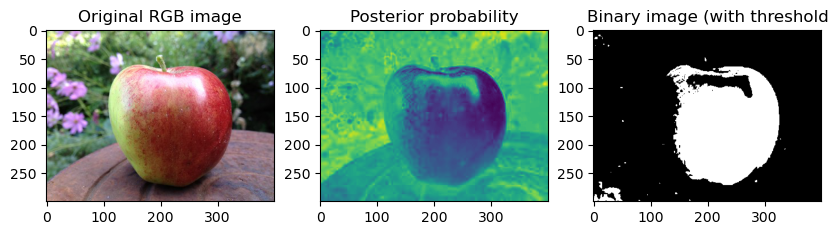

In [187]:
# Thresholding to obtain a binary image, and plotting

test_pos_0_bis = np.copy(test_pos_0)

t_0 = 0.45

test_pos_0_bis[test_pos_0 > t_0] = 0
test_pos_0_bis[test_pos_0 <= t_0] = 1

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(TestImgs[0])
plt.title("Original RGB image")
plt.subplot(132)
plt.imshow(test_pos_0)
plt.title("Posterior probability")
plt.subplot(133)
plt.imshow(test_pos_0_bis, cmap='gray')
plt.title("Binary image (with threshold")

In [173]:
test_pos_1 = getResultLike(TestImgs[1], mixGaussEstApple, mixGaussEstNonApple, priorApple, priorNonApple)

Text(0.5, 1.0, 'Binary image (with threshold')

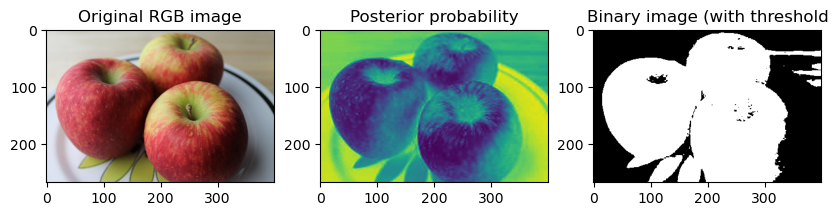

In [188]:
test_pos_1_bis = np.copy(test_pos_1)

t_1 = 0.5

test_pos_1_bis[test_pos_1 > t_1] = 0
test_pos_1_bis[test_pos_1 <= t_1] = 1

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(TestImgs[1])
plt.title("Original RGB image")
plt.subplot(132)
plt.imshow(test_pos_1)
plt.title("Posterior probability")
plt.subplot(133)
plt.imshow(test_pos_1_bis, cmap='gray')
plt.title("Binary image (with threshold")

In [175]:
test_pos_2 = getResultLike(TestImgs[2], mixGaussEstApple, mixGaussEstNonApple, priorApple, priorNonApple)

Text(0.5, 1.0, 'Binary image (with threshold')

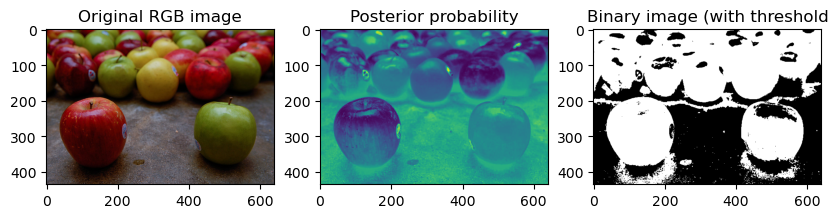

In [189]:
test_pos_2_bis = np.copy(test_pos_2)

t_2 = 0.5

test_pos_2_bis[test_pos_2 > t_2] = 0
test_pos_2_bis[test_pos_2 <= t_2] = 1

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(TestImgs[2])
plt.title("Original RGB image")
plt.subplot(132)
plt.imshow(test_pos_2)
plt.title("Posterior probability")
plt.subplot(133)
plt.imshow(test_pos_2_bis, cmap='gray')
plt.title("Binary image (with threshold")

In [177]:
test_pos_3 = getResultLike(TestImgs[3], mixGaussEstApple, mixGaussEstNonApple, priorApple, priorNonApple)

Text(0.5, 1.0, 'Binary image (with threshold')

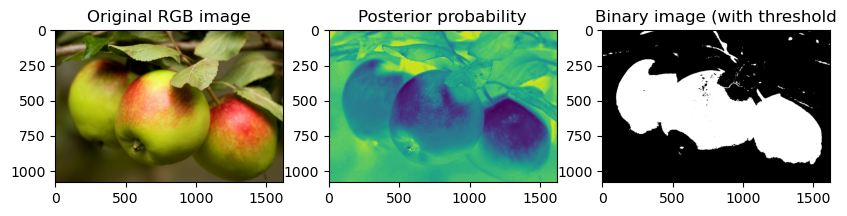

In [190]:
test_pos_3_bis = np.copy(test_pos_3)

t_3 = 0.4

test_pos_3_bis[test_pos_3 > t_3] = 0
test_pos_3_bis[test_pos_3 <= t_3] = 1

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(TestImgs[3])
plt.title("Original RGB image")
plt.subplot(132)
plt.imshow(test_pos_3)
plt.title("Posterior probability")
plt.subplot(133)
plt.imshow(test_pos_3_bis, cmap='gray')
plt.title("Binary image (with threshold")

In [179]:
test_pos_4 = getResultLike(TestImgs[4], mixGaussEstApple, mixGaussEstNonApple, priorApple, priorNonApple)

Text(0.5, 1.0, 'Binary image (with threshold')

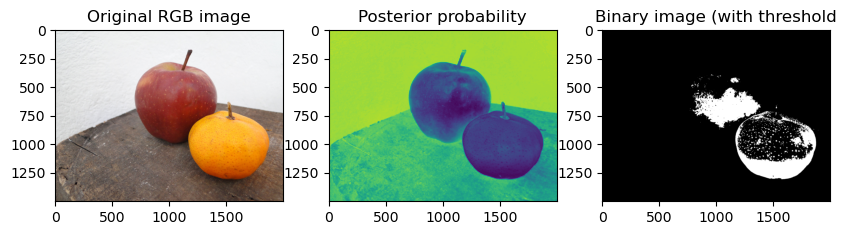

In [194]:
test_pos_4_bis = np.copy(test_pos_4)

t_4 = 0.29

test_pos_4_bis[test_pos_4 > t_4] = 0
test_pos_4_bis[test_pos_4 <= t_4] = 1

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(TestImgs[4])
plt.title("Original RGB image")
plt.subplot(132)
plt.imshow(test_pos_4)
plt.title("Posterior probability")
plt.subplot(133)
plt.imshow(test_pos_4_bis, cmap='gray')
plt.title("Binary image (with threshold")

Here is a recap of the plots we have:

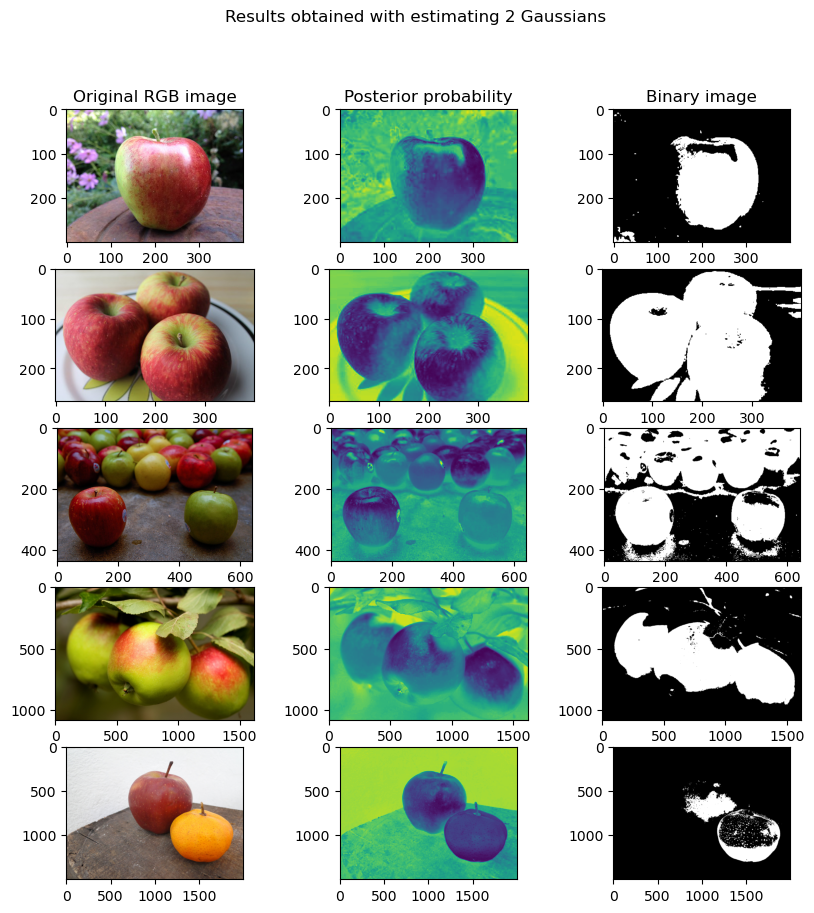

In [195]:
plt.figure(figsize=(10,10))
plt.subplot(531)
plt.imshow(TestImgs[0])
plt.title("Original RGB image")
plt.subplot(532)
plt.imshow(test_pos_0)
plt.title("Posterior probability")
plt.subplot(533)
plt.imshow(test_pos_0_bis, cmap='gray')
plt.title("Binary image")
plt.subplot(534)
plt.imshow(TestImgs[1])
plt.subplot(535)
plt.imshow(test_pos_1)
plt.subplot(536)
plt.imshow(test_pos_1_bis, cmap='gray')
plt.subplot(537)
plt.imshow(TestImgs[2])
plt.subplot(538)
plt.imshow(test_pos_2)
plt.subplot(539)
plt.imshow(test_pos_2_bis, cmap='gray')
plt.subplot(5,3,10)
plt.imshow(TestImgs[3])
plt.subplot(5,3,11)
plt.imshow(test_pos_3)
plt.subplot(5,3,12)
plt.imshow(test_pos_3_bis, cmap='gray')
plt.subplot(5,3,13)
plt.imshow(TestImgs[4])
plt.subplot(5,3,14)
plt.imshow(test_pos_4)
plt.subplot(5,3,15)
plt.imshow(test_pos_4_bis, cmap='gray')
plt.suptitle("Results obtained with estimating 2 Gaussians")
plt.show()

_Comment :_ We can see that our model identifies successfully the apples in every image. Nevertheless, we can see that it picks up some green details on the plate in the second image, and identifies the clementine on the last image as an apple. But at the same time, we can see that the model does not pick up the leaves on the fourth image. It is maybe because some apples have hues of orange/red, and therefore our model makes the connection "orange/red = apple", or has done an average of red+green. We would need more Gaussians in the mixture to be able to make more precise differences in the hues of color.

Let's also note that we have applied a threshold to every result to obtain a binary image, and that this thresholding can also have an impact on the quality of our result. Above, we have selected a t manually, but let's quantify this with the ROC curves below.

In [182]:
TP_frac_0, FP_frac_0 = ROC_curve(test_pos_0, cv2.cvtColor(TestGroundTruth[0], cv2.COLOR_BGR2GRAY)) 

In [183]:
TP_frac_1, FP_frac_1 = ROC_curve(test_pos_1, cv2.cvtColor(TestGroundTruth[1], cv2.COLOR_BGR2GRAY)) 

In [184]:
TP_frac_4, FP_frac_4 = ROC_curve(test_pos_4, cv2.cvtColor(TestGroundTruth[2], cv2.COLOR_BGR2GRAY)) 

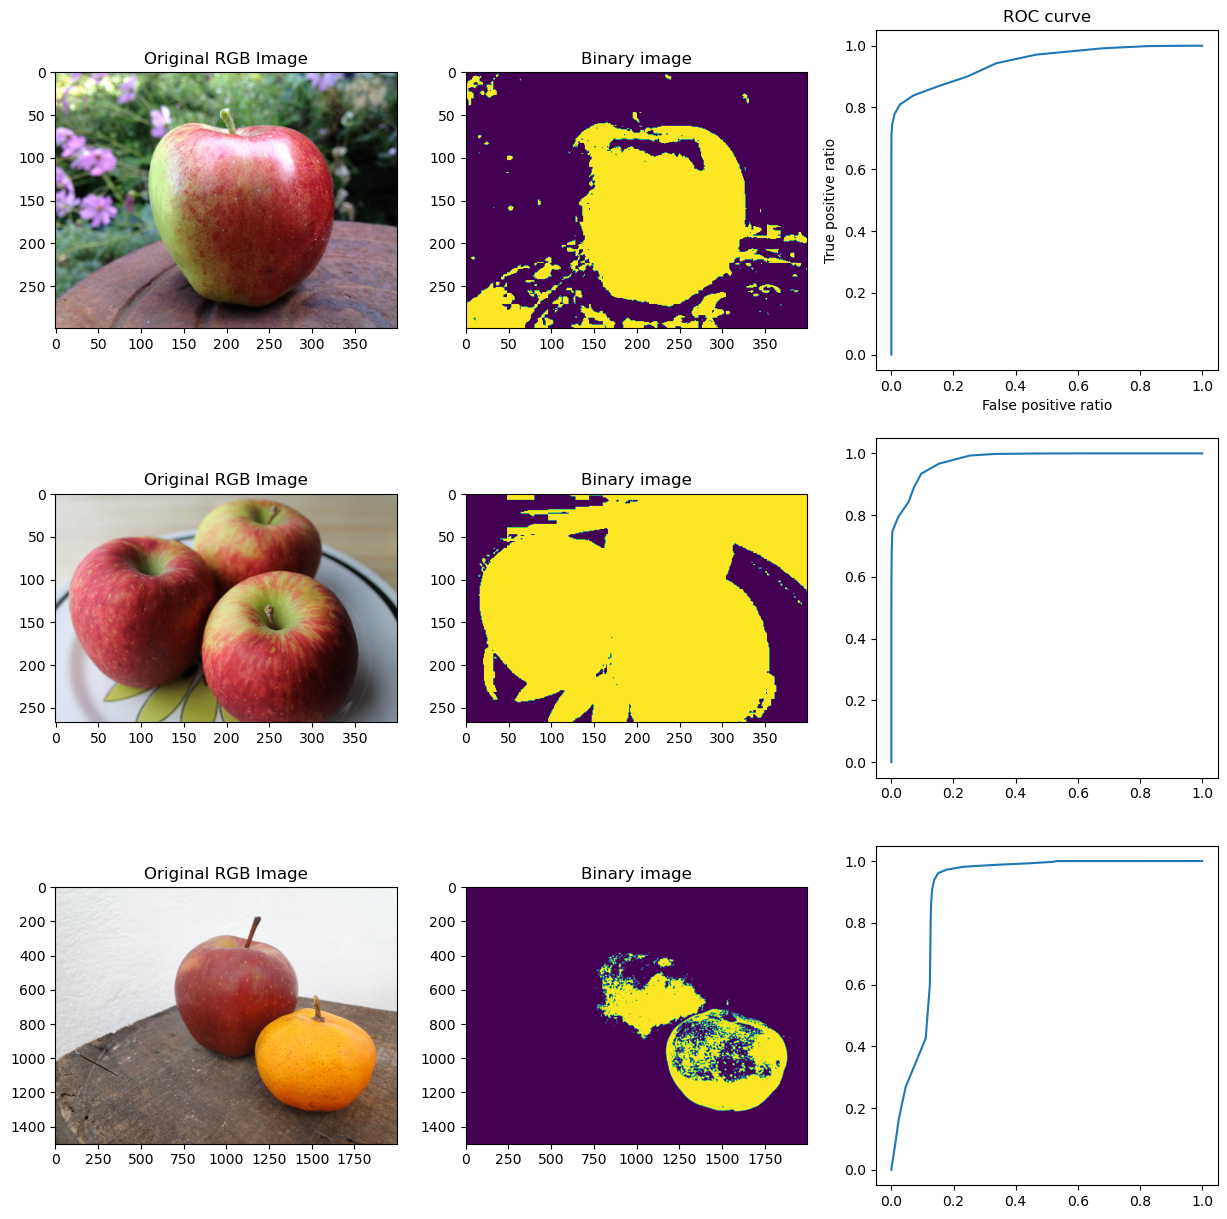

In [185]:
# Plotting

plt.figure(figsize=(15,15))
plt.subplot(331)
plt.imshow(TestImgs[0])
plt.title("Original RGB Image")
plt.subplot(332)
plt.imshow(test_pos_0_bis)
plt.title("Binary image")
plt.subplot(333)
plt.plot(FP_frac_0, TP_frac_0)
plt.xlabel("False positive ratio")
plt.ylabel("True positive ratio")
plt.title("ROC curve")
plt.subplot(334)
plt.imshow(TestImgs[1])
plt.title("Original RGB Image")
plt.subplot(335)
plt.imshow(test_pos_1_bis)
plt.title("Binary image")
plt.subplot(336)
plt.plot(FP_frac_1, TP_frac_1)
plt.subplot(337)
plt.imshow(TestImgs[4])
plt.title("Original RGB Image")
plt.subplot(338)
plt.imshow(test_pos_4_bis)
plt.title("Binary image")
plt.subplot(339)
plt.plot(FP_frac_4, TP_frac_4)

_Comment:_ Despite our noisy results, we still achieve quite good ROC curves, which prove that our model performs well, and that there exists an optimal threshold that can optimize the SNR of our result.

We have run the test multiple times, and it seems that a higher number of Gaussians would be needed. Here for 2 Gaussians, we see that the background gets separated quite nicely, but on the last image, the orange clementine is marked as an apple, which is an error. When running the code another time, the model would rejet the clementine, which is good, but conversely it would pick up more background noise, resulting in worse results (you can check the Results_2_Gaussians.png). So for a low number of Gaussians, we might get good results, but there will always be details left off.

We also ran the program with n = 3 Gaussian, and the results were frankly not that good either (you can check the Results_3_Gaussians.png), so the solution might be to take a higher number of Gaussians. 

**Why should we use three separate sets of files: a training set, a validation set, and a test set?**

Currently, we only use two separate sets of files: a training set and a test set. The first defines the parameters of our model, and the second will get these parameters applied to it in order to compute a score giving us an idea of the performance of our model. But some parameters are not trainable or trainable with difficulty: the hyperparameters. In our case, two hyperparameters would be the priors: we have fixed the priors only based on the information provided by the training set, but we get no additionnal information from the testing set, whereas in the latest, we have images where apples are much bigger than in the training set, that should have therefore resulted in a bigger priorApple. We should therefore introduce a **validation set** that takes into account this kind of additional information.